# **Итоговый проект Deep Learning (семестр 1, осень 2025)**

**Студент**: Михаил Киселёв

**Stepik ID**: 1027756045

# 2. Модель распознавания лиц

In [5]:
#!pip -q install dlib
!pip -q install pytorch-metric-learning

# 2.1. Скачивание датасета

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [12]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", dataset_path)

100%|██████████| 112M/112M [00:20<00:00, 5.66MB/s] 

Extracting files...


Path to dataset files: C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4


# 2.2. Предобработка и BaseLine

In [14]:
# @title Dataset исходных изображений

class BaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Собираем все изображения
        for person in os.listdir(root_dir):
            person_dir = os.path.join(root_dir, person)
            if os.path.isdir(person_dir):
                for img_name in os.listdir(person_dir):
                    if img_name.endswith('.jpg'):
                        self.image_paths.append(os.path.join(person_dir, img_name))
                        self.labels.append(person)

        # Создаем mapping для меток
        self.label_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        #print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        label = self.label_to_idx[self.labels[idx]]
        #print(self.labels[idx])
        return image, label, img_path

In [18]:
#dataset = BaseDataset('/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled', transform=None)
dataset = BaseDataset(r'C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled', transform=None)

In [19]:
dataset[0][0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(250, 250, 3), dtype=uint8)

In [20]:
dataset[0][1]

3166

In [21]:
dataset[0][2]

'C:\\Users\\mvkiselev\\.cache\\kagglehub\\datasets\\jessicali9530\\lfw-dataset\\versions\\4\\lfw-deepfunneled\\lfw-deepfunneled\\Aaron_Eckhart\\Aaron_Eckhart_0001.jpg'

Далее, будет произведён Baseline анализ для определения границ оценки качества самрписной модели распознавания лиц.

In [22]:
# @title Dataset выровненных изображений. Выравнивание с помощью dlib. Используется для сравнения с Dataset выровненных изображений с помощью нейросети

import dlib

class AlignedDatasetBaseLine(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Собираем все изображения
        for person in os.listdir(root_dir):
            person_dir = os.path.join(root_dir, person)
            if os.path.isdir(person_dir):
                for img_name in os.listdir(person_dir):
                    if img_name.endswith('.jpg'):
                        self.image_paths.append(os.path.join(person_dir, img_name))
                        self.labels.append(person)

        # Создаем mapping для меток
        self.label_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

        # Скачиваем модель если нужно
        if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
            print("Скачивание модели dlib...")
            os.system("wget -nc http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2")
            os.system("bzip2 -d shape_predictor_68_face_landmarks.dat.bz2")

        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

        # Исключить из датасета изображения людей для которых менее чем 3 изображения
        #from collections import Counter
        #
        #counts = Counter(self.labels)
        #self.image_paths = [p for p, l in zip(self.image_paths, self.labels) if counts[l] >= 3]
        #self.labels = [l for l in self.labels if counts[l] >= 3]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)

        # Конвертируем BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Для детектора нужен серый цвет
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        faces = self.detector(gray)
        if len(faces) == 0:
            label = self.label_to_idx[self.labels[idx]]
            if self.transform:
                return self.transform(image), label, img_path
            else:
                return image, label, img_path

        shape = self.predictor(gray, faces[0])
        aligned_image = dlib.get_face_chip(image, shape, size=250)

        if self.transform:
            aligned_image = self.transform(aligned_image)

        label = self.label_to_idx[self.labels[idx]]
        return aligned_image, label, img_path


In [25]:
dataset_aligned = AlignedDatasetBaseLine(r'C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled', transform=None)

array([[[152, 149, 158],
        [156, 153, 161],
        [164, 160, 167],
        ...,
        [194, 207, 212],
        [194, 206, 212],
        [194, 204, 212]],

       [[162, 160, 168],
        [165, 163, 171],
        [170, 168, 175],
        ...,
        [180, 193, 199],
        [180, 191, 199],
        [180, 190, 199]],

       [[176, 175, 181],
        [178, 176, 183],
        [180, 179, 185],
        ...,
        [171, 184, 190],
        [174, 185, 193],
        [176, 186, 195]],

       ...,

       [[211, 192, 183],
        [225, 200, 187],
        [235, 206, 189],
        ...,
        [218, 217, 221],
        [217, 217, 220],
        [217, 218, 219]],

       [[185, 158, 149],
        [201, 170, 156],
        [213, 178, 160],
        ...,
        [217, 217, 221],
        [217, 217, 220],
        [216, 218, 220]],

       [[154, 119, 110],
        [172, 132, 118],
        [186, 142, 123],
        ...,
        [217, 218, 221],
        [217, 218, 221],
        [217, 219, 220]]], dtype=uint8)
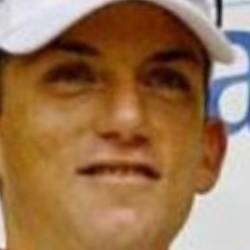

In [11]:
dataset_aligned[0][0]

In [26]:
dataset[0][1]

3166

In [27]:
print(f'Число классов: {len(dataset_aligned.label_to_idx)}')

Число классов: 5749


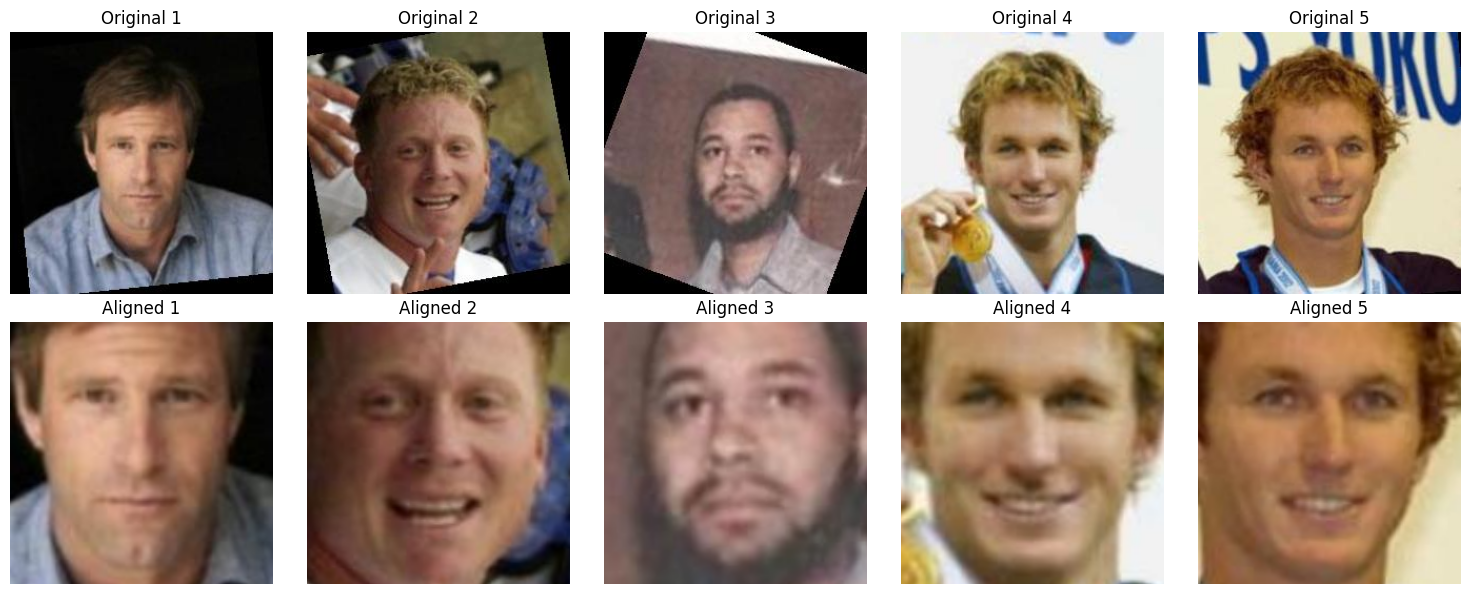

In [28]:
import matplotlib.pyplot as plt

def show_datasets(dataset, dataset_aligned, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Первый ряд - исходный датасет
    for i in range(num_samples):
        img, label, path = dataset[i] if len(dataset[i]) == 3 else (dataset[i][0], dataset[i][1], '')
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original {i+1}")

    # Второй ряд - выровненный датасет
    for i in range(num_samples):
        img, label, path = dataset_aligned[i] if len(dataset_aligned[i]) == 3 else (dataset_aligned[i][0], dataset_aligned[i][1], '')
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Aligned {i+1}")

    plt.tight_layout()
    plt.show()

show_datasets(dataset, dataset_aligned)

In [29]:
# @title Распознавание лиц BaseLine

import torchvision.models as models
import torch.nn.functional as F

class ModelBaseLine(nn.Module):
    def __init__(self, num_classes, embedding_size=512):
        super().__init__()
        # Используем предобученный ResNet
        self.backbone = models.resnet18(pretrained=True) #weights='IMAGENET1K_V1'
        #self.backbone.fc = nn.Linear(512, embedding_size)
        self.backbone.fc = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, embedding_size),
            nn.BatchNorm1d(embedding_size) # Очень полезно для ArcFace
        )
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward_simple(self, x):
        x = x.float()
        embedding = self.backbone(x)
        return embedding

    def forward(self, x):
        x = x.float()
        # L2 нормализация эмбеддинга
        embedding = F.normalize(self.backbone(x), p=2, dim=1)
        return embedding


In [30]:
from pytorch_metric_learning import losses

class FaceRecognitionPipelineBaseLine:
    def __init__(self, num_classes):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = ModelBaseLine(num_classes).to(self.device)
        self.num_classes = num_classes
        self.accuracy = []
        self.loss = []

    def train(self, train_loader, val_loader, num_epochs=10):
        # PyTorch ArcFaceLoss Baseline
        arcface_loss_fn = losses.ArcFaceLoss(
            num_classes=self.num_classes,
            embedding_size=512,
            margin=0.35, #0.5,
            scale=32 #64.0
        ).to(self.device)

        # Веса ArcFace (arcface_loss_fn.weight) — это центры классов, они обязаны обучаться вместе с моделью.
        # Без этого модель будет пытаться подстроиться под случайный шум
        optimizer = optim.Adam([
            {'params': self.model.parameters(), 'lr': 1e-3},
            {'params': arcface_loss_fn.parameters(), 'lr': 1e-3} # Добавляем параметры лосса! - здесь была ошибка
        ], lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0

            for batch_idx, (images, labels, _) in enumerate(tqdm(train_loader)):
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()

                embeddings = self.model(images)
                loss = arcface_loss_fn(embeddings, labels)
                loss.backward()

                optimizer.step()
                total_loss += loss.item()

            scheduler.step()

            # Валидация
            self.model.eval()
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels, _ in val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = self.model(images)
                    logits = arcface_loss_fn.get_logits(outputs)
                    _, predicted = torch.max(logits, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            self.accuracy.append(accuracy)
            self.loss.append(total_loss/len(train_loader))
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, '
                  f'Accuracy: {accuracy:.2f}%')

In [33]:
def main(num_epochs=13):
    # Создаем датасет
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(), # Обязательно для лиц
        transforms.RandomRotation(10),
        transforms.Resize((224, 224)), # Для ResNet
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Добавить обязательно
    ])

    dataset = AlignedDatasetBaseLine(r'C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled', transform=transform)

    train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2) #stratify=dataset.labels)

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    pipeline = FaceRecognitionPipelineBaseLine(num_classes=len(dataset.label_to_idx))

    pipeline.train(train_loader, val_loader, num_epochs=num_epochs)

    return pipeline

In [35]:
pipeline = main(num_epochs=15)

100%|██████████| 166/166 [05:21<00:00,  1.93s/it]


Epoch 1/15, Loss: 8.4517, Accuracy: 6.57%


100%|██████████| 166/166 [04:41<00:00,  1.70s/it]


Epoch 2/15, Loss: 7.1322, Accuracy: 16.85%


100%|██████████| 166/166 [04:41<00:00,  1.69s/it]


Epoch 3/15, Loss: 6.3949, Accuracy: 17.91%


100%|██████████| 166/166 [04:43<00:00,  1.71s/it]


Epoch 4/15, Loss: 5.8568, Accuracy: 23.27%


100%|██████████| 166/166 [04:45<00:00,  1.72s/it]


Epoch 5/15, Loss: 5.3074, Accuracy: 23.12%


100%|██████████| 166/166 [04:52<00:00,  1.76s/it]


Epoch 6/15, Loss: 4.4467, Accuracy: 29.51%


100%|██████████| 166/166 [04:50<00:00,  1.75s/it]


Epoch 7/15, Loss: 4.1559, Accuracy: 30.37%


100%|██████████| 166/166 [04:48<00:00,  1.74s/it]


Epoch 8/15, Loss: 3.9656, Accuracy: 31.02%


100%|██████████| 166/166 [04:46<00:00,  1.73s/it]


Epoch 9/15, Loss: 3.7698, Accuracy: 32.41%


100%|██████████| 166/166 [04:46<00:00,  1.73s/it]


Epoch 10/15, Loss: 3.5667, Accuracy: 32.38%


100%|██████████| 166/166 [04:45<00:00,  1.72s/it]


Epoch 11/15, Loss: 3.2922, Accuracy: 32.68%


100%|██████████| 166/166 [04:45<00:00,  1.72s/it]


Epoch 12/15, Loss: 3.2464, Accuracy: 33.13%


100%|██████████| 166/166 [04:42<00:00,  1.70s/it]


Epoch 13/15, Loss: 3.2196, Accuracy: 32.79%


100%|██████████| 166/166 [04:50<00:00,  1.75s/it]


Epoch 14/15, Loss: 3.1830, Accuracy: 32.94%


100%|██████████| 166/166 [04:47<00:00,  1.73s/it]


Epoch 15/15, Loss: 3.1606, Accuracy: 33.51%


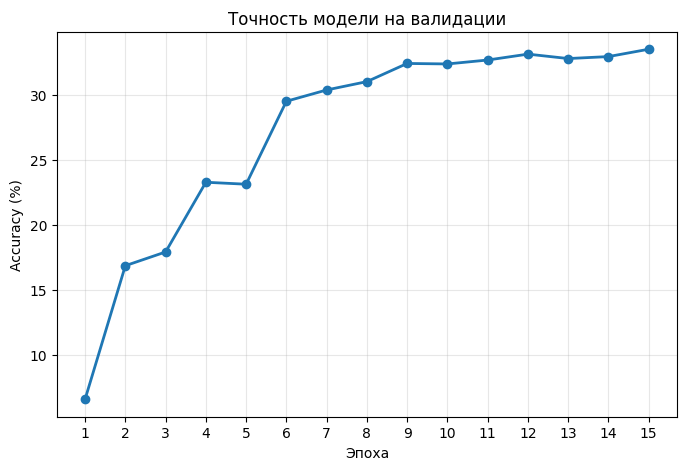

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.accuracy) + 1), pipeline.accuracy, marker='o', linewidth=2)
plt.title('Точность модели на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.accuracy) + 1))
plt.show()

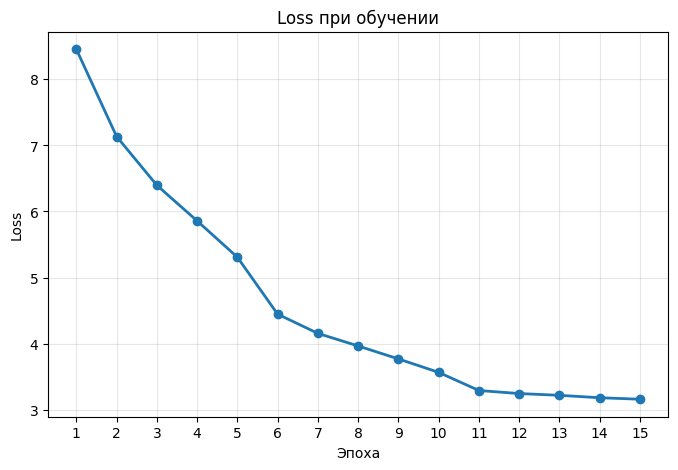

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.loss) + 1), pipeline.loss, marker='o', linewidth=2)
plt.title('Loss при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.loss) + 1))
plt.show()

**Вывод**: Достигнутая accuracy ~32%. Резюме LLM по поводу достигнутой точности: Цель — именно классификация на LFW, то 30-40% для 5000+ классов — это на самом деле не так уж плохо для ResNet18. После train_test_split осталось более 2000 классов, что означает, что 30% — это в сотни раз лучше случайного угадывания.

**Результат**: Базовая точность ~32%

# 2.3. Детекция ключевых точек

In [38]:
if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

In [39]:
import dlib
import numpy as np

In [40]:
class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

        # Инициализируем детектор лица dlib
        self.detector = dlib.get_frontal_face_detector()
        predictor_path = "shape_predictor_68_face_landmarks.dat"
        self.predictor = dlib.shape_predictor(predictor_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Детекция лица и ключевых точек с помощью dlib
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        faces = self.detector(gray)

        if len(faces) > 0:
            shape = self.predictor(gray, faces[0])
            landmarks = np.array([[p.x, p.y] for p in shape.parts()])

            # Нормализуем координаты
            h, w = image.shape[:2]
            landmarks = landmarks / np.array([w, h])  # Нормализация к [0, 1]
        else:
            # Если лицо не обнаружено, используем средние значения
            landmarks = np.zeros((68, 2)) + 0.5

        if self.transform:
            image = self.transform(image)

        return image, torch.FloatTensor(landmarks.flatten())

In [41]:
# NME — средняя ошибка, нормализованная на межзрачковое расстояние (Inter-ocular distance)

NME = []

def calculate_NME(pred, target):
    """
    pred_points: (68, 2) в пикселях
    true_points: (68, 2) в пикселях
    """
    # Конвертируем в numpy, если это тензоры
    if torch.is_tensor(pred):
        pred = pred.detach().cpu().numpy()
    if torch.is_tensor(target):
        target = target.detach().cpu().numpy()

    # Меняем форму из [136] в [68, 2] для удобства расчетов
    pred = pred.reshape(-1, 2)
    target = target.reshape(-1, 2)

    # Расчет межзрачкового расстояния по таргету
    left_eye = target[36:42].mean(axis=0)
    right_eye = target[42:48].mean(axis=0)
    d_interocular = np.linalg.norm(left_eye - right_eye)

    # Средняя ошибка по всем точкам
    rmse = np.mean(np.linalg.norm(pred - target, axis=1))

    # Если лицо слишком маленькое или d_interocular близок к 0,
    # возвращаем rmse, чтобы избежать деления на ноль
    if d_interocular < 1e-6:
        return rmse

    return rmse / d_interocular

In [42]:
from torch.optim.lr_scheduler import StepLR

In [43]:
class FaceLandmarkNet(nn.Module):
    def __init__(self, num_points=68):
        super(FaceLandmarkNet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_points * 2),  # x,y координаты для каждой точки
            nn.Sigmoid() # Чтобы координаты были в [0, 1]
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # Возвращаем (Batch, 136). Это сразу готово для сравнения с landmarks из датасета
        #return x
        return x.view(x.size(0), -1, 2)

def train_landmark_model(image_paths, num_epochs=20):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    dataset = LandmarkDataset(image_paths[:2000], transform=transform)  # Используем часть данных
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = FaceLandmarkNet(num_points=68)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, landmarks in tqdm(train_loader):
            images, landmarks = images.to(device), landmarks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # outputs shape: (batch, 68, 2)
            # landmarks shape: (batch, 136)
            pred_landmarks = outputs.view(landmarks.size(0), -1)
            loss = criterion(pred_landmarks, landmarks)
            eye_loss = criterion(pred_landmarks[:, 36*2:48*2], landmarks[:, 36*2:48*2])
            combine_loss = loss + eye_loss * 2  # Удваиваем важность глаз - Борьба за меньший NME (начальный вариант ~0.11, надо ~0.05)

            #loss.backward()
            combine_loss.backward()
            optimizer.step()
            total_loss += loss.item()

            NME.append(calculate_NME(pred_landmarks.detach().cpu(), landmarks.detach().cpu()))

        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.6f}')

    torch.save(model.state_dict(), 'face_landmark_model.pth')
    return model

In [45]:
image_paths = []
for person in os.listdir(r'C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled'):
    person_dir = os.path.join(r'C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled', person)
    if os.path.isdir(person_dir):
        for img_name in os.listdir(person_dir):
            if img_name.endswith('.jpg'):
                image_paths.append(os.path.join(person_dir, img_name))
print(f"Найдено {len(image_paths)} изображений")

Найдено 13233 изображений


In [46]:
train_landmark_model(image_paths, num_epochs=20)

100%|██████████| 125/125 [00:24<00:00,  5.14it/s]


Epoch 1/20, Loss: 0.002597


100%|██████████| 125/125 [00:24<00:00,  5.15it/s]


Epoch 2/20, Loss: 0.001324


100%|██████████| 125/125 [00:24<00:00,  5.21it/s]


Epoch 3/20, Loss: 0.001152


100%|██████████| 125/125 [00:23<00:00,  5.22it/s]


Epoch 4/20, Loss: 0.001106


100%|██████████| 125/125 [00:23<00:00,  5.23it/s]


Epoch 5/20, Loss: 0.001034


100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


Epoch 6/20, Loss: 0.000990


100%|██████████| 125/125 [00:23<00:00,  5.21it/s]


Epoch 7/20, Loss: 0.000959


100%|██████████| 125/125 [00:24<00:00,  5.13it/s]


Epoch 8/20, Loss: 0.000924


100%|██████████| 125/125 [00:24<00:00,  5.16it/s]


Epoch 9/20, Loss: 0.000926


100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


Epoch 10/20, Loss: 0.000871


100%|██████████| 125/125 [00:24<00:00,  5.19it/s]


Epoch 11/20, Loss: 0.000805


100%|██████████| 125/125 [00:24<00:00,  5.19it/s]


Epoch 12/20, Loss: 0.000800


100%|██████████| 125/125 [00:24<00:00,  5.15it/s]


Epoch 13/20, Loss: 0.000793


100%|██████████| 125/125 [00:24<00:00,  5.14it/s]


Epoch 14/20, Loss: 0.000794


100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


Epoch 15/20, Loss: 0.000790


100%|██████████| 125/125 [00:24<00:00,  5.15it/s]


Epoch 16/20, Loss: 0.000779


100%|██████████| 125/125 [00:24<00:00,  5.19it/s]


Epoch 17/20, Loss: 0.000779


100%|██████████| 125/125 [00:24<00:00,  5.18it/s]


Epoch 18/20, Loss: 0.000764


100%|██████████| 125/125 [00:24<00:00,  5.20it/s]


Epoch 19/20, Loss: 0.000771


100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


Epoch 20/20, Loss: 0.000769


FaceLandmarkNet(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [47]:
NME[-5:]

[np.float32(0.12767918),
 np.float32(0.11701531),
 np.float32(0.14629556),
 np.float32(0.086500965),
 np.float32(0.14533487)]

In [48]:
sum(NME[-5:]) / 5

np.float32(0.124565184)

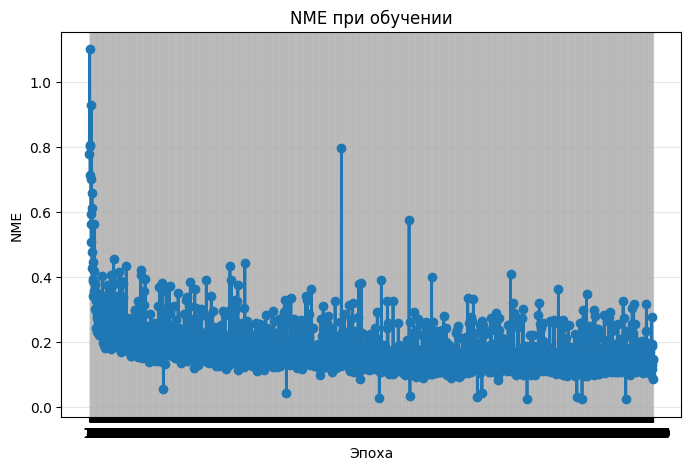

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(NME) + 1), NME, marker='o', linewidth=2)
plt.title('NME при обучении')
plt.xlabel('Эпоха')
plt.ylabel('NME')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(NME) + 1))
plt.show()

**Результат**: NME ~0.12 (12%) для самодельной модели — это хороший результат, но для качественного выравнивания лиц (Alignment) под ArcFace этого маловато. Стоить отметить, что NME от запуска к запуску меняется в диапазоне 0.07-0.13, наблюдается нестабильность. Скорее всего слабовата модель FaceLandmarkNet. Я экспериментировал с вычислением Loss, это помогло - на некоторых запусках NME ~0.07, но всё равно сказывается, видимо, слабость модели. Нужны ещё дополнительные эксперименты.

В задачах детекции точек лица (Facial Landmark Detection) значения интерпретируются так:
•	NME < 0.05 (5%): Отличный результат, точки стоят почти идеально.
•	NME 0.05–0.08: Хороший результат, пригоден для выравнивания.
•	NME > 0.10: Точки "плавают". На 12% глаза и губы будут смещены, что может снизить точность распознавания лиц (ArcFace) на 10-15%.


# 2.4. Выравнивание лиц

In [50]:
class FaceAlignerByNet:
    def __init__(self, model_path='face_landmark_model.pth'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.landmark_model = FaceLandmarkNet(num_points=68)
        self.landmark_model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.landmark_model.eval()
        self.landmark_model.to(self.device)

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def get_landmarks(self, image):
        """Получаем ключевые точки с помощью обученной модели"""
        with torch.no_grad():
            img_tensor = self.transform(image).unsqueeze(0).to(self.device)
            landmarks = self.landmark_model(img_tensor)

            # Денормализуем координаты
            h, w = image.shape[:2]
            landmarks = landmarks.cpu().numpy()[0]
            landmarks[:, 0] *= w
            landmarks[:, 1] *= h

        return landmarks

    def align_face(self, image, target_size=(128, 128)):
        landmarks = self.get_landmarks(image)

        left_eye_center = landmarks[36:42].mean(axis=0)
        right_eye_center = landmarks[42:48].mean(axis=0)

        # 1. Считаем угол
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dy, dx))

        # 2. Вычисляем масштаб (чтобы расстояние между глазами было фиксированным)
        # Это сделает все лица в датасете одного масштаба
        desired_left_eye = (0.35, 0.4) # Желаемая позиция в % (x, y)
        dist = np.sqrt(dx**2 + dy**2)
        desired_dist = (0.7 - 0.35) * target_size[0] # 70% - 35% ширины
        scale = desired_dist / dist

        # 3. Центр вращения
        eyes_center = ((left_eye_center[0] + right_eye_center[0]) / 2,
                      (left_eye_center[1] + right_eye_center[1]) / 2)

        # 4. Получаем матрицу и корректируем перенос (translation)
        M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

        # Смещение, чтобы центр глаз оказался в идеальной точке нового кадра
        t_x = target_size[0] * 0.5
        t_y = target_size[1] * 0.4 # Глаза чуть выше центра по вертикали
        M[0, 2] += (t_x - eyes_center[0])
        M[1, 2] += (t_y - eyes_center[1])

        # 5. Одним действием и поворачиваем, и масштабируем, и центрируем
        aligned = cv2.warpAffine(image, M, target_size, borderMode=cv2.BORDER_REPLICATE)

        return aligned

In [51]:
class CustomAlignedDataset(Dataset):
    def __init__(self, root_dir, aligner, transform=None):
        self.root_dir = root_dir
        self.aligner = aligner
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Собираем все изображения
        for person in os.listdir(root_dir):
            person_dir = os.path.join(root_dir, person)
            if os.path.isdir(person_dir):
                for img_name in os.listdir(person_dir):
                    if img_name.endswith('.jpg'):
                        self.image_paths.append(os.path.join(person_dir, img_name))
                        self.labels.append(person)

        # Создаем mapping для меток
        self.label_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Загружаем и выравниваем изображение
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.aligner.align_face(image)

        if self.transform:
            image = self.transform(image)

        label = self.label_to_idx[self.labels[idx]]
        return image, label, img_path

In [52]:
custom_aligner = FaceAlignerByNet(model_path='face_landmark_model.pth')
custom_dataset_aligned = CustomAlignedDataset(r'C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled', aligner=custom_aligner, transform=None)

Ниже dataset выровненный изображений лиц с помощью самописной модели - FaceLandmarkNet

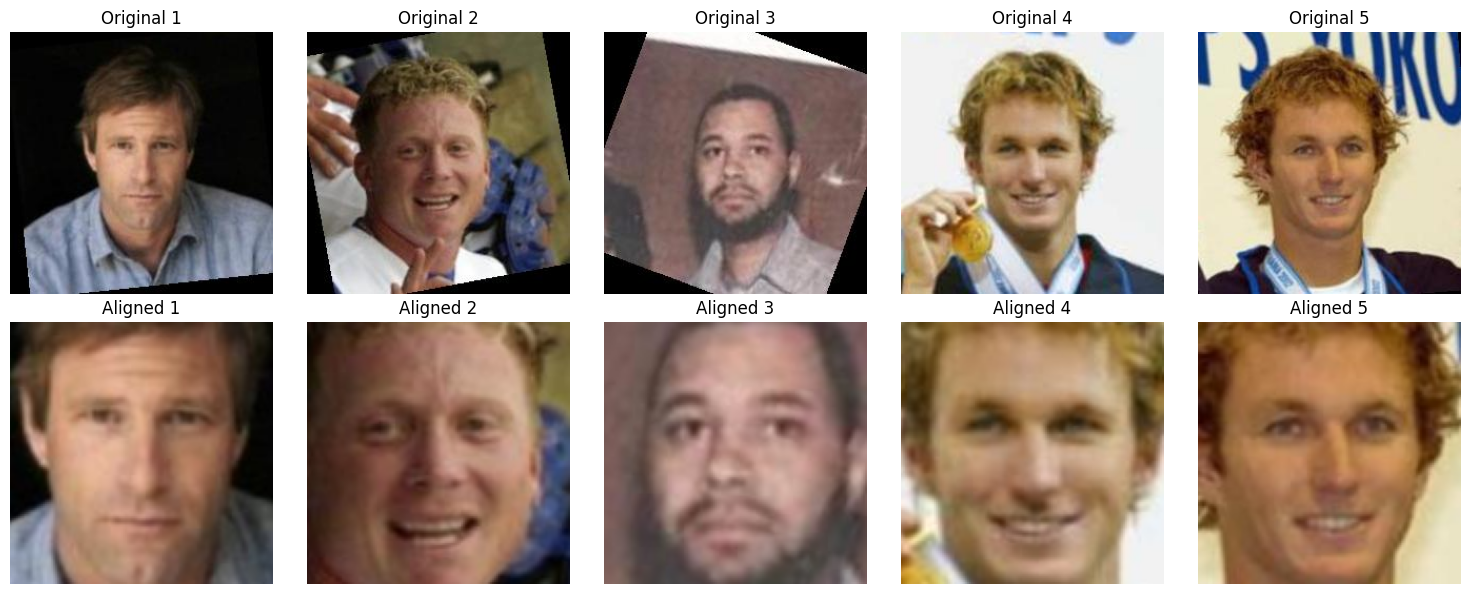

In [53]:
show_datasets(dataset, custom_dataset_aligned)

# 2.5. Модель распознавания

In [54]:
import torch.nn.functional as F

In [55]:
class FaceRecognitionModel(nn.Module):
    def __init__(self, embedding_size=512, num_classes=None):
        super().__init__()
        self.embedding_size = embedding_size

        # Энкодер (Backbone)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, embedding_size),
            nn.BatchNorm1d(embedding_size) # BatchNorm здесь помогает стабилизировать эмбеддинги
        )
        # Добавляем обычный классификатор для CE
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0), -1)
        embedding = self.fc(features)

        # Для обычного CE отдаем логиты из ненормализованного эмбеддинга
        logits = self.classifier(embedding)

        # КРИТИЧЕСКИ ВАЖНО ДЛЯ ARCFACE: L2-нормализация
        embedding = F.normalize(embedding, p=2, dim=1)

        return embedding, logits

In [56]:
import torchvision.models as models

class FaceRecognitionModeBasedOnResnet18(nn.Module):
    def __init__(self, num_classes, embedding_size=512):
        super().__init__()
        # Используем предобученный ResNet
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(512, embedding_size)
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x, return_embedding=True):
        embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.classifier(embedding)

# 2.6. Функции потерь

In [57]:
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features=512, num_classes=None, s=64.0, m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.s = s
        self.m = m

        # Правильный способ инициализации весов в nn.Module
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, in_features))
        print(f"Classes: {num_classes} Features: {in_features}")
        nn.init.xavier_uniform_(self.weight)

        self.ce = nn.CrossEntropyLoss()

    def forward(self, embeddings, labels):
        # 1. Нормализация весов и эмбеддингов
        # (Ожидаем, что они уже на одном устройстве благодаря .to() модели)
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.weight))

        # 2. Вычисление угла (theta)
        theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))

        # 3. Применяем маржу
        target_logits = torch.cos(theta + self.m)

        # 4. Обновляем косинусы только для целевых индексов
        # Используем scatter_ для более эффективной работы, чем one_hot
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1.0)

        output = cosine + one_hot * (target_logits - cosine)

        # 5. Масштабирование
        output *= self.s

        return self.ce(output, labels)

### ID Rate

В задачах распознавания лиц ID Rate (часто называемая Rank-1 Accuracy) — это метрика, которая показывает, как часто истинный класс (ID человека) оказывается на первом месте среди предсказаний модели.
В контексте ArcFace, где классификатор — это центры классов на гиперсфере, ID Rate вычисляется через косинусное сходство между эмбеддингом изображения и весами (центрами) всех классов в слое ArcFace.

In [58]:
def compute_id_rate(embeddings, labels, arcface_weights):
    """
    Рассчитывает Rank-1 Accuracy (ID Rate)
    """
    with torch.no_grad():
        # Важно: веса ArcFace тоже нужно нормализовать перед умножением
        w_norm = F.normalize(arcface_weights, p=2, dim=1)

        # Считаем косинусы (логиты без маржи)
        # embeddings уже нормализованы в вашей модели FaceRecognitionModel
        logits = F.linear(embeddings, w_norm)

        _, predicted = torch.max(logits, 1)
        correct = (predicted == labels).sum().item()
        return correct

# 2.7. Полный пайплайн

In [ ]:
class FaceRecognitionPipeline:
    def __init__(self, num_classes, model_path=None, loss_mode='arcface'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = FaceRecognitionModel(embedding_size=512, num_classes=num_classes).to(self.device)
        self.aligner = FaceAlignerByNet()
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        self.num_classes = num_classes
        self.loss_mode = loss_mode
        self.loss = []
        self.accuracy = []
        self.id_rate = []

    def preprocess_image(self, image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        aligned = self.aligner.align_face(image)
        tensor = self.transform(aligned).unsqueeze(0)
        return tensor.to(self.device)

    def extract_embedding(self, image_path):
        tensor = self.preprocess_image(image_path)
        with torch.no_grad():
            embedding = self.model(tensor)
        return embedding.cpu().numpy()

    def train(self, train_loader, val_loader, num_epochs=10):
        criterion_ce = nn.CrossEntropyLoss()
        arcface_loss_fn = ArcFaceLoss(in_features=512, num_classes=self.num_classes).to(self.device)

        # 2. Передаем ВСЕ параметры в оптимизатор
        optimizer = optim.Adam([
            {'params': self.model.parameters()},
            {'params': arcface_loss_fn.parameters()}
        ], lr=0.001)

        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0

            for images, labels, _ in tqdm(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()

                # Получаем эмбеддинг (он уже L2-нормализован в модели)
                embeddings, logits = self.model(images)

                if self.loss_mode == 'arcface':
                    # Используем ArcFaceLoss
                    loss = arcface_loss_fn(embeddings, labels)
                elif self.loss_mode == 'ce':
                    # Используем CE Loss
                    loss = criterion_ce(logits, labels)
                else:
                    # Используем ArcFaceLoss + CE Loss
                    loss = arcface_loss_fn(embeddings, labels) + criterion_ce(logits, labels)

                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            scheduler.step()

            # Валидация
            self.model.eval()
            correct, total = 0, 0
            val_correct, val_total = 0, 0
            with torch.no_grad():
                for images, labels, _ in val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    embeddings, _ = self.model(images)

                    # Чтобы получить предсказания в ArcFace, считаем близость к весам
                    # Косинусное сходство между эмбеддингами и обученными весами классов
                    logits = F.linear(F.normalize(embeddings), F.normalize(arcface_loss_fn.weight))

                    _, predicted = torch.max(logits, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    val_correct += compute_id_rate(embeddings, labels, arcface_loss_fn.weight)
                    val_total += labels.size(0)

            self.accuracy.append(100 * correct / total)
            self.loss.append(total_loss/len(train_loader))
            self.id_rate.append(100 * val_correct / val_total)

            print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))

# 2.8. Обучение и оценка

In [60]:
image_paths = []
for person in os.listdir(r'C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled'):
    person_dir = os.path.join(r'C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled', person)
    if os.path.isdir(person_dir):
        for img_name in os.listdir(person_dir):
            if img_name.endswith('.jpg'):
                image_paths.append(os.path.join(person_dir, img_name))
print(f"Найдено {len(image_paths)} изображений")

Найдено 13233 изображений


In [61]:
image_paths[0]

'C:\\Users\\mvkiselev\\.cache\\kagglehub\\datasets\\jessicali9530\\lfw-dataset\\versions\\4\\lfw-deepfunneled\\lfw-deepfunneled\\Aaron_Eckhart\\Aaron_Eckhart_0001.jpg'

In [62]:
len(dataset.label_to_idx)

5749

In [65]:
def main(num_epochs=10, model_path='face_landmark_model.pth', loss_mode='arcface'):
    # Обучаем модель ключевых точек (только если нужно)
    if not os.path.exists(model_path):
        print("Обучение модели ключевых точек...")
        train_landmark_model(image_paths, num_epochs=20)
    else:
        print("Используется ранее обученная модель ключевых точек...")

    # Создаем FaceAligner с обученной моделью
    aligner = FaceAlignerByNet(model_path=model_path)

    # Пример использования
    print(f'Test Image File Path: {image_paths[0]}')
    test_image = cv2.imread(image_paths[0])
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    aligned_face = aligner.align_face(test_image)

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(test_image)
    axes[0].set_title('Исходное изображение')
    axes[1].imshow(aligned_face)
    axes[1].set_title('Выровненное лицо')
    plt.show()

    transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    dataset = CustomAlignedDataset(
        r'C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled',
        aligner=aligner,
        transform=transform)

    # Разделяем данные
    train_idx, val_idx = train_test_split(
        range(len(dataset)),
        test_size=0.2) #stratify=dataset.labels)

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Инициализируем пайплайн
    pipeline = FaceRecognitionPipeline(num_classes=len(dataset.label_to_idx), model_path=model_path, loss_mode=loss_mode)

    # Обучаем модель
    pipeline.train(train_loader, val_loader, num_epochs=num_epochs)

    # Сохраняем модель
    pipeline.save_model('face_recognition_model.pth')

    # Пример использования
    #sample_image = dataset.image_paths[0]
    #embedding = pipeline.extract_embedding(sample_image)
    #print(f"Размер эмбеддинга: {embedding.shape}")

    return pipeline

Используется ранее обученная модель ключевых точек...
Test Image File Path: C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled\Aaron_Eckhart\Aaron_Eckhart_0001.jpg


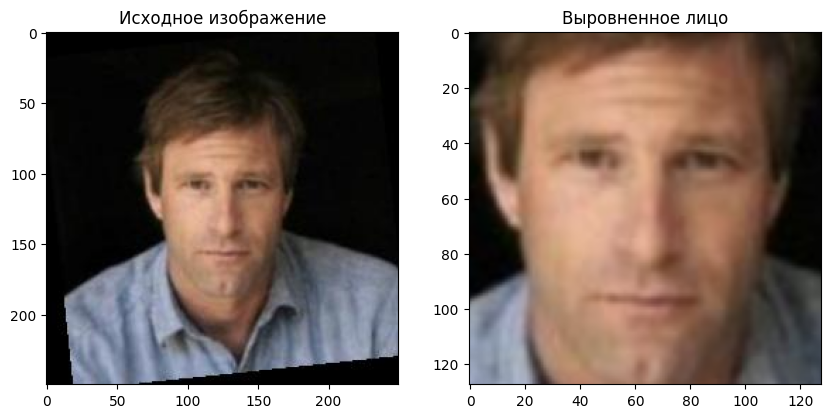

Classes: 5749 Features: 512


100%|██████████| 331/331 [02:08<00:00,  2.57it/s]


Epoch 1, Loss: 43.5493, Accuracy: 4.12%


100%|██████████| 331/331 [02:10<00:00,  2.54it/s]


Epoch 2, Loss: 41.4182, Accuracy: 8.54%


100%|██████████| 331/331 [02:15<00:00,  2.45it/s]


Epoch 3, Loss: 36.6598, Accuracy: 14.54%


100%|██████████| 331/331 [02:14<00:00,  2.47it/s]


Epoch 4, Loss: 31.1669, Accuracy: 20.06%


100%|██████████| 331/331 [02:14<00:00,  2.46it/s]


Epoch 5, Loss: 25.8139, Accuracy: 23.23%


100%|██████████| 331/331 [02:15<00:00,  2.45it/s]


Epoch 6, Loss: 18.0459, Accuracy: 26.67%


100%|██████████| 331/331 [02:14<00:00,  2.47it/s]


Epoch 7, Loss: 16.5008, Accuracy: 27.01%


100%|██████████| 331/331 [02:13<00:00,  2.48it/s]


Epoch 8, Loss: 15.5073, Accuracy: 27.39%


100%|██████████| 331/331 [02:14<00:00,  2.46it/s]


Epoch 9, Loss: 14.6908, Accuracy: 27.92%


100%|██████████| 331/331 [02:14<00:00,  2.47it/s]


Epoch 10, Loss: 13.9760, Accuracy: 28.26%


100%|██████████| 331/331 [02:15<00:00,  2.45it/s]


Epoch 11, Loss: 12.8641, Accuracy: 28.52%


100%|██████████| 331/331 [02:15<00:00,  2.44it/s]


Epoch 12, Loss: 12.6921, Accuracy: 28.45%


100%|██████████| 331/331 [02:14<00:00,  2.47it/s]


Epoch 13, Loss: 12.6555, Accuracy: 28.71%


100%|██████████| 331/331 [02:14<00:00,  2.47it/s]


Epoch 14, Loss: 12.5688, Accuracy: 28.90%


100%|██████████| 331/331 [02:12<00:00,  2.49it/s]


Epoch 15, Loss: 12.4735, Accuracy: 28.71%


100%|██████████| 331/331 [02:16<00:00,  2.43it/s]


Epoch 16, Loss: 12.3277, Accuracy: 28.83%


100%|██████████| 331/331 [02:15<00:00,  2.45it/s]


Epoch 17, Loss: 12.3300, Accuracy: 28.71%


100%|██████████| 331/331 [02:14<00:00,  2.45it/s]


Epoch 18, Loss: 12.3168, Accuracy: 28.60%


100%|██████████| 331/331 [02:14<00:00,  2.46it/s]


Epoch 19, Loss: 12.2963, Accuracy: 28.75%


100%|██████████| 331/331 [02:13<00:00,  2.49it/s]


Epoch 20, Loss: 12.3421, Accuracy: 29.01%


In [66]:
# ArcFace Loss
pipeline = main(num_epochs=20, model_path='face_landmark_model.pth', loss_mode='arcface')

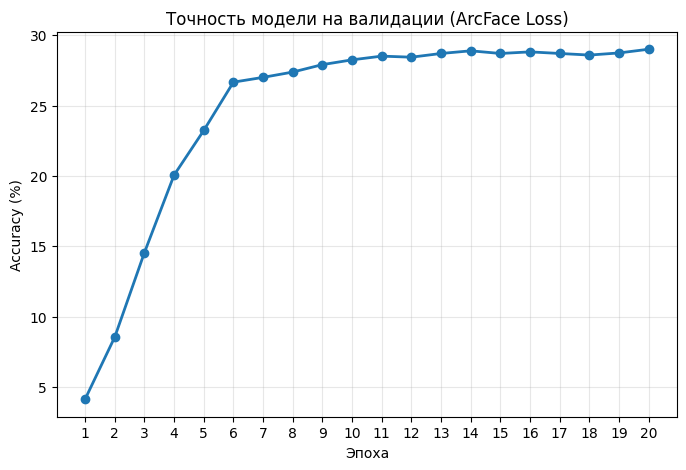

In [67]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.accuracy) + 1), pipeline.accuracy, marker='o', linewidth=2)
plt.title('Точность модели на валидации (ArcFace Loss)')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.accuracy) + 1))
plt.show()

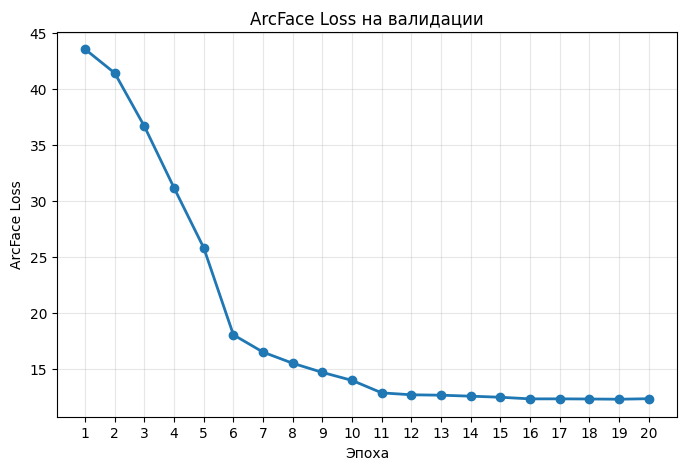

In [68]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.loss) + 1), pipeline.loss, marker='o', linewidth=2)
plt.title('ArcFace Loss на валидации')
plt.xlabel('Эпоха')
plt.ylabel('ArcFace Loss')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.loss) + 1))
plt.show()

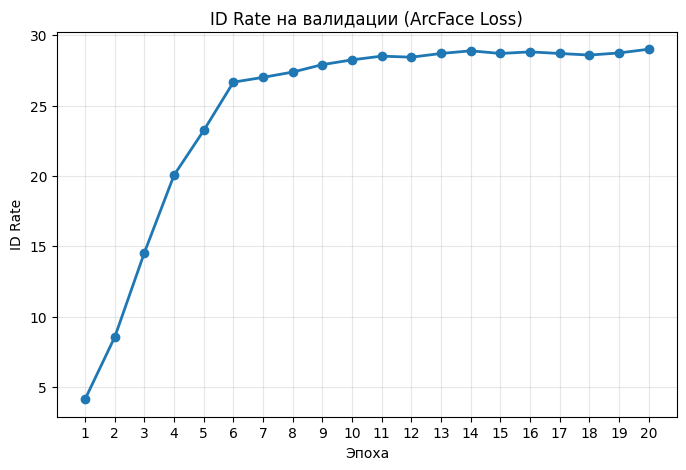

In [69]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.id_rate) + 1), pipeline.id_rate, marker='o', linewidth=2)
plt.title('ID Rate на валидации (ArcFace Loss)')
plt.xlabel('Эпоха')
plt.ylabel('ID Rate')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.id_rate) + 1))
plt.show()

Используется ранее обученная модель ключевых точек...
Test Image File Path: C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled\Aaron_Eckhart\Aaron_Eckhart_0001.jpg


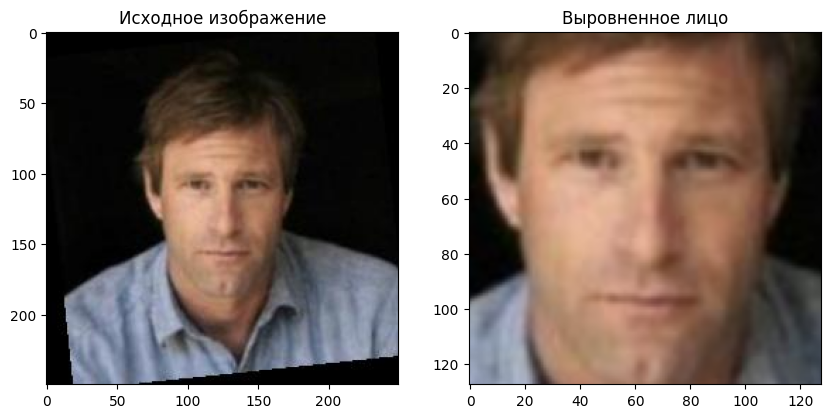

Classes: 5749 Features: 512


100%|██████████| 331/331 [02:10<00:00,  2.54it/s]


Epoch 1, Loss: 8.0361, Accuracy: 7.37%


100%|██████████| 331/331 [02:09<00:00,  2.55it/s]


Epoch 2, Loss: 6.2026, Accuracy: 12.81%


100%|██████████| 331/331 [02:09<00:00,  2.56it/s]


Epoch 3, Loss: 4.1719, Accuracy: 17.23%


100%|██████████| 331/331 [02:09<00:00,  2.55it/s]


Epoch 4, Loss: 2.0452, Accuracy: 21.72%


100%|██████████| 331/331 [02:06<00:00,  2.62it/s]


Epoch 5, Loss: 0.7122, Accuracy: 24.06%


100%|██████████| 331/331 [02:09<00:00,  2.56it/s]


Epoch 6, Loss: 0.1952, Accuracy: 27.47%


100%|██████████| 331/331 [02:10<00:00,  2.54it/s]


Epoch 7, Loss: 0.1190, Accuracy: 27.77%


100%|██████████| 331/331 [02:10<00:00,  2.53it/s]


Epoch 8, Loss: 0.0902, Accuracy: 28.30%


100%|██████████| 331/331 [02:07<00:00,  2.60it/s]


Epoch 9, Loss: 0.0702, Accuracy: 28.83%


100%|██████████| 331/331 [02:05<00:00,  2.64it/s]


Epoch 10, Loss: 0.0583, Accuracy: 28.64%


100%|██████████| 331/331 [02:05<00:00,  2.65it/s]


Epoch 11, Loss: 0.0464, Accuracy: 28.52%


100%|██████████| 331/331 [02:05<00:00,  2.65it/s]


Epoch 12, Loss: 0.0461, Accuracy: 28.71%


100%|██████████| 331/331 [02:04<00:00,  2.65it/s]


Epoch 13, Loss: 0.0435, Accuracy: 28.52%


100%|██████████| 331/331 [02:04<00:00,  2.65it/s]


Epoch 14, Loss: 0.0439, Accuracy: 28.71%


100%|██████████| 331/331 [02:04<00:00,  2.66it/s]


Epoch 15, Loss: 0.0420, Accuracy: 28.75%


100%|██████████| 331/331 [02:06<00:00,  2.62it/s]


Epoch 16, Loss: 0.0404, Accuracy: 28.86%


100%|██████████| 331/331 [02:06<00:00,  2.62it/s]


Epoch 17, Loss: 0.0412, Accuracy: 28.64%


100%|██████████| 331/331 [02:02<00:00,  2.70it/s]


Epoch 18, Loss: 0.0408, Accuracy: 28.71%


100%|██████████| 331/331 [02:01<00:00,  2.73it/s]


Epoch 19, Loss: 0.0400, Accuracy: 28.83%


100%|██████████| 331/331 [02:03<00:00,  2.69it/s]


Epoch 20, Loss: 0.0401, Accuracy: 28.71%


In [71]:
# CE Loss
pipeline = main(num_epochs=20, model_path='face_landmark_model.pth', loss_mode='ce')

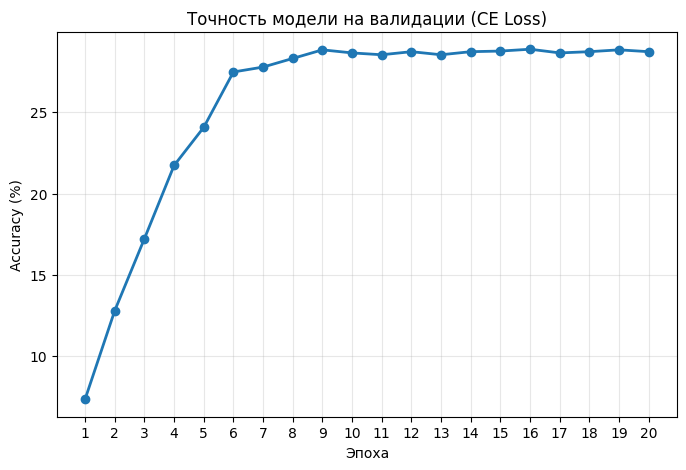

In [72]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.accuracy) + 1), pipeline.accuracy, marker='o', linewidth=2)
plt.title('Точность модели на валидации (CE Loss)')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.accuracy) + 1))
plt.show()

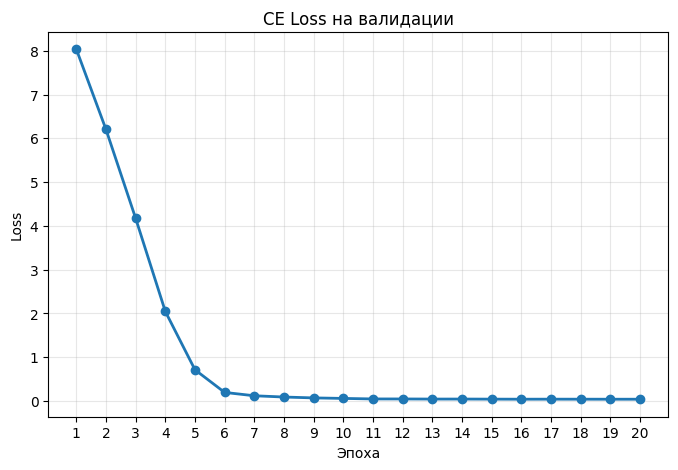

In [73]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.loss) + 1), pipeline.loss, marker='o', linewidth=2)
plt.title('CE Loss на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.loss) + 1))
plt.show()

Используется ранее обученная модель ключевых точек...
Test Image File Path: C:\Users\mvkiselev\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled\Aaron_Eckhart\Aaron_Eckhart_0001.jpg


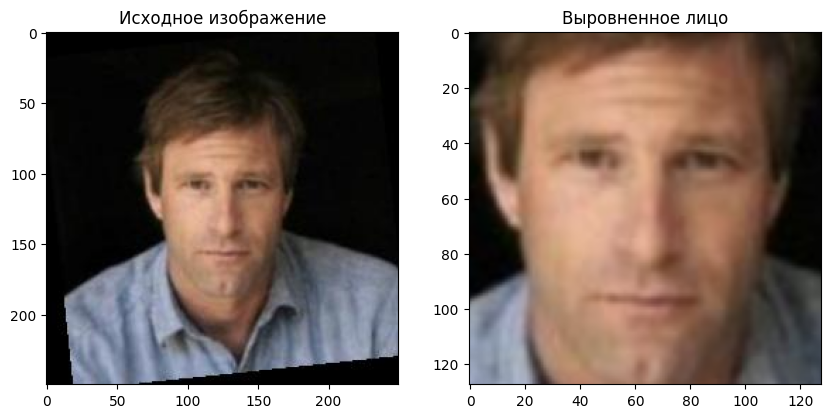

Classes: 5749 Features: 512


100%|██████████| 331/331 [02:06<00:00,  2.63it/s]


Epoch 1, Loss: 51.7011, Accuracy: 3.66%


100%|██████████| 331/331 [02:04<00:00,  2.65it/s]


Epoch 2, Loss: 47.3783, Accuracy: 11.22%


100%|██████████| 331/331 [02:10<00:00,  2.54it/s]


Epoch 3, Loss: 39.9666, Accuracy: 16.09%


100%|██████████| 331/331 [02:13<00:00,  2.48it/s]


Epoch 4, Loss: 32.0585, Accuracy: 21.57%


100%|██████████| 331/331 [02:11<00:00,  2.52it/s]


Epoch 5, Loss: 24.9314, Accuracy: 26.52%


100%|██████████| 331/331 [02:10<00:00,  2.53it/s]


Epoch 6, Loss: 16.4828, Accuracy: 29.28%


100%|██████████| 331/331 [02:08<00:00,  2.57it/s]


Epoch 7, Loss: 14.9109, Accuracy: 30.03%


100%|██████████| 331/331 [02:10<00:00,  2.53it/s]


Epoch 8, Loss: 14.0048, Accuracy: 30.68%


100%|██████████| 331/331 [02:11<00:00,  2.51it/s]


Epoch 9, Loss: 13.1652, Accuracy: 30.94%


100%|██████████| 331/331 [02:11<00:00,  2.51it/s]


Epoch 10, Loss: 12.3837, Accuracy: 31.70%


100%|██████████| 331/331 [02:11<00:00,  2.51it/s]


Epoch 11, Loss: 11.3308, Accuracy: 31.89%


100%|██████████| 331/331 [02:11<00:00,  2.51it/s]


Epoch 12, Loss: 11.1975, Accuracy: 32.30%


100%|██████████| 331/331 [02:12<00:00,  2.49it/s]


Epoch 13, Loss: 11.1231, Accuracy: 31.96%


100%|██████████| 331/331 [13:35:53<00:00, 147.90s/it]      


Epoch 14, Loss: 11.0423, Accuracy: 32.23%


100%|██████████| 331/331 [02:10<00:00,  2.54it/s]


Epoch 15, Loss: 10.9830, Accuracy: 32.19%


100%|██████████| 331/331 [02:12<00:00,  2.49it/s]


Epoch 16, Loss: 10.8526, Accuracy: 32.19%


100%|██████████| 331/331 [02:14<00:00,  2.46it/s]


Epoch 17, Loss: 10.8278, Accuracy: 32.15%


100%|██████████| 331/331 [02:14<00:00,  2.46it/s]


Epoch 18, Loss: 10.8324, Accuracy: 32.15%


100%|██████████| 331/331 [02:10<00:00,  2.54it/s]


Epoch 19, Loss: 10.8340, Accuracy: 31.85%


100%|██████████| 331/331 [02:12<00:00,  2.50it/s]


Epoch 20, Loss: 10.7722, Accuracy: 32.26%


In [74]:
# Mixed Loss
pipeline = main(num_epochs=20, model_path='face_landmark_model.pth', loss_mode='mixed')

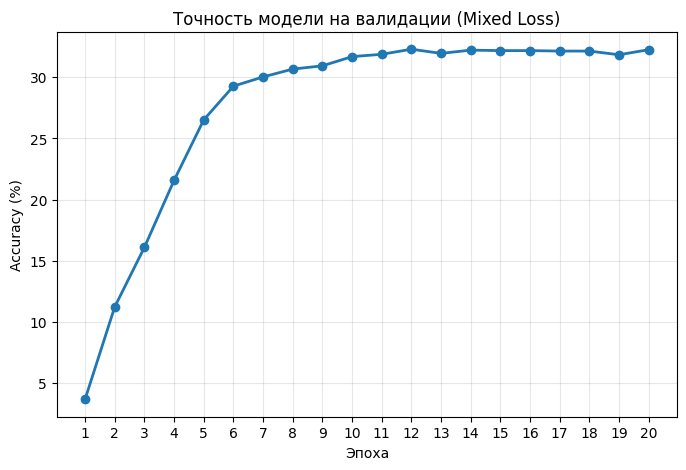

In [75]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.accuracy) + 1), pipeline.accuracy, marker='o', linewidth=2)
plt.title('Точность модели на валидации (Mixed Loss)')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.accuracy) + 1))
plt.show()

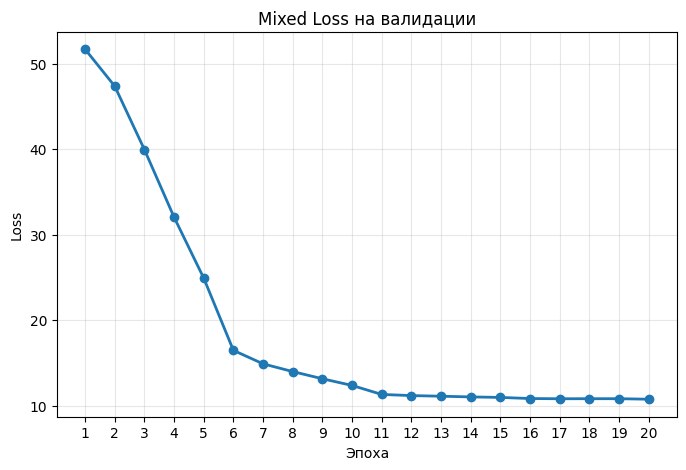

In [76]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.loss) + 1), pipeline.loss, marker='o', linewidth=2)
plt.title('Mixed Loss на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.loss) + 1))
plt.show()

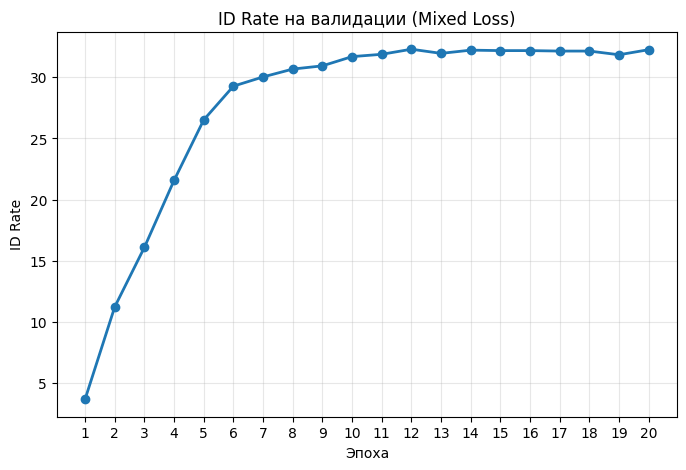

In [77]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pipeline.id_rate) + 1), pipeline.id_rate, marker='o', linewidth=2)
plt.title('ID Rate на валидации (Mixed Loss)')
plt.xlabel('Эпоха')
plt.ylabel('ID Rate')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pipeline.id_rate) + 1))
plt.show()

**Выводы**: В целом, удалось собрать, на мой взгляд, неплохую модель распознвания лиц. Точность примерно равна точности baseline-модели. Результат ID Rate ≈ 30% для датасета LFW — это средний результат, который указывает на то, что модель начала обучаться, но еще не достигла высокого качества. В наборе данных 5749 классов (как в полном LFW) - шанс угадать случайно составляет 0.017%. Мои 30% — это в 1700 раз лучше, чем случайный выбор. Модель явно выучила черты лиц. Можно было бы использовать больший датасет, сделать фильтрацию по количеству изображений для одного человека (что повысит NME, а это в свою очередь повысит ID Rate), попытаться реализовать Tripple Loss, изменить формирование датасета выровненных изображений лиц (предварительно за один проход), да ещё много чего можно было бы сделать. Правильные решения появляются сразу после завершения работ по проекту.

На мой взгляд, дальнейшее развитие технологии по распознаванию лиц будет идти в напралении 3D, поскольку является более надёжным способом распознавания. Но 2D технологии попрежнему актуальны, поскольку в большинстве сценариев распознавания лиц доступны только 2D данные.